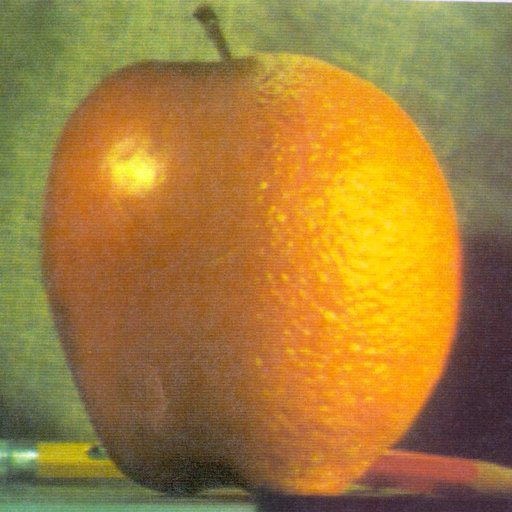

True

In [141]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def gaussianPyramid(image, count):
  pyramid = image.copy()
  returnGaussian = [np.float32(pyramid)]  # Save first img

  for i in range(count):
    pyramid = cv2.pyrDown(pyramid)  # Downsample
    returnGaussian.append(np.float32(pyramid))  # Save

  return returnGaussian

def laplacianPyramid(gausPyr, count):
  minGaussian = gausPyr[-1]  # Last gaussian is minimum-sized gaussian
  returnLaplacian = [minGaussian]  # Starts with minimum
  for i in range(count, 0, -1):
    size = (gausPyr[i - 1].shape[1], gausPyr[i - 1].shape[0])  # Calculate size to upsample
    gausUpscale = cv2.pyrUp(gausPyr[i], dstsize = size)  # Upsample with calculated size
    lpl = cv2.subtract(gausPyr[i-1], gausUpscale)  # Subtract small but upsampled img from bigger img to obtain laplacian
    returnLaplacian.append(lpl)  # Save

  return returnLaplacian

def prepareMask(shape, xStart, xEnd, yStart, yEnd):
  mask = np.zeros((shape[0],shape[1],3), dtype='float32')  # Arrage an all 0's image with given size
  mask[xStart : xEnd, yStart : yEnd] = (1, 1, 1)  # Slightly brighten the blending part
  return mask


# Main starts here
main = cv2.imread("/content/sample_data/apple.jpg")  # main image
other = cv2.imread("/content/sample_data/orange.jpg")  # image part
layerCount = 50  # gaussian-laplacian layer count

# This Mask part is change with input. You can find the code fragment that should be used for the following part from "README.txt".
#############################################################
mask = prepareMask(main.shape, 0, main.shape[0], main.shape[0] // 2, main.shape[0])
#############################################################

# PART 1 - Build Laplacian pyramids for each image.

mainGaussian = gaussianPyramid(main, layerCount)  # Calculate gaussian pyramid for main
mainLaplacian = laplacianPyramid(mainGaussian, layerCount)  # Calculate laplacian pyramid for main

otherGaussian = gaussianPyramid(other, layerCount)  # Calculate gaussian pyramid for other
otherLaplacian = laplacianPyramid(otherGaussian, layerCount)  # Calculate laplacian pyramid for other

# PART 2 - Build a Gaussian pyramid for each region mask.

maskGaussian = gaussianPyramid(mask, layerCount)  # Calculate gaussian pyramid for mask
maskGaussian.reverse()  # Reverse for same order as laplacians

# PART 3 - Blend each level of pyramid using region mask from the same level

finalLaplacian = []  # Save blended laplacians
for mainL,otherL,maskG in zip(mainLaplacian, otherLaplacian, maskGaussian):
  # (Laplacian of first image * Gaussian of mask) + (Laplacian of second image * (1 - Gaussian of mask))
  fnlLap = (otherL * maskG) + (mainL * (1.0 - maskG))
  finalLaplacian.append(fnlLap)


# PART 4 - Collapse the pyramid to get the final blended image.

fnlImg = finalLaplacian[0]
finalImage = [fnlImg]  # Save reconstructed steps
for i in range(layerCount):
  size = (finalLaplacian[i + 1].shape[1], finalLaplacian[i + 1].shape[0])  # Calculate size to upsample
  fnlImg = cv2.pyrUp(fnlImg, dstsize = size)  # Upsample with calculated size
  fnlImg = cv2.add(finalLaplacian[i + 1], fnlImg)  # Add small but upsampled laplacian to bigger laplacian to obtain blended image
  finalImage.append(fnlImg)

cv2_imshow(finalImage[layerCount])  # Last reconstructed step is the normal sized blended image
cv2.imwrite("/content/sample_data/appleorange - 7.jpg", finalImage[layerCount])  # To save blended image
cv2.imwrite("/content/sample_data/appleorange.jpg", mask)  # To save mask